In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 27.0 MB/s eta 0:00:00


##**Разведочный анализ данны**х

   id   age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0  55.0       150.0        50.0       73.0             0.8   
1   1  50.0       160.0        60.0       79.6             1.0   
2   2  55.0       145.0        50.0       73.0             1.2   
3   3  40.0       175.0        80.0       83.2             0.9   
4   4  30.0       170.0        70.0       79.5             1.2   

   eyesight(right)  hearing(left)  hearing(right)  systolic  ...   HDL    LDL  \
0              1.0            1.0             1.0     122.0  ...  62.0  113.0   
1              0.8            1.0             1.0     124.0  ...  74.0  112.0   
2              1.2            1.0             1.0     110.0  ...  66.0  123.0   
3              1.0            1.0             1.0      99.0  ...  38.0  114.0   
4              1.2            1.0             1.0     119.0  ...  49.0  148.0   

   hemoglobin  Urine protein  serum creatinine   AST   ALT   Gtp  \
0        12.0            1.0               0.6  

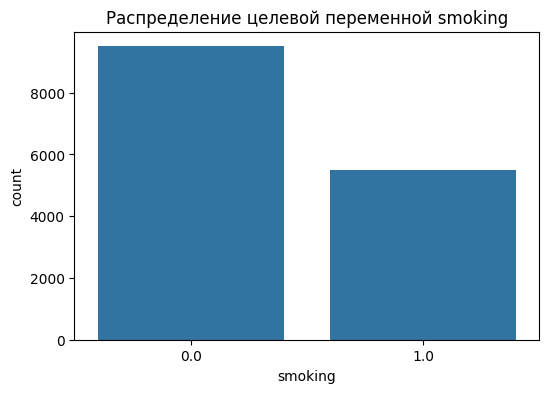

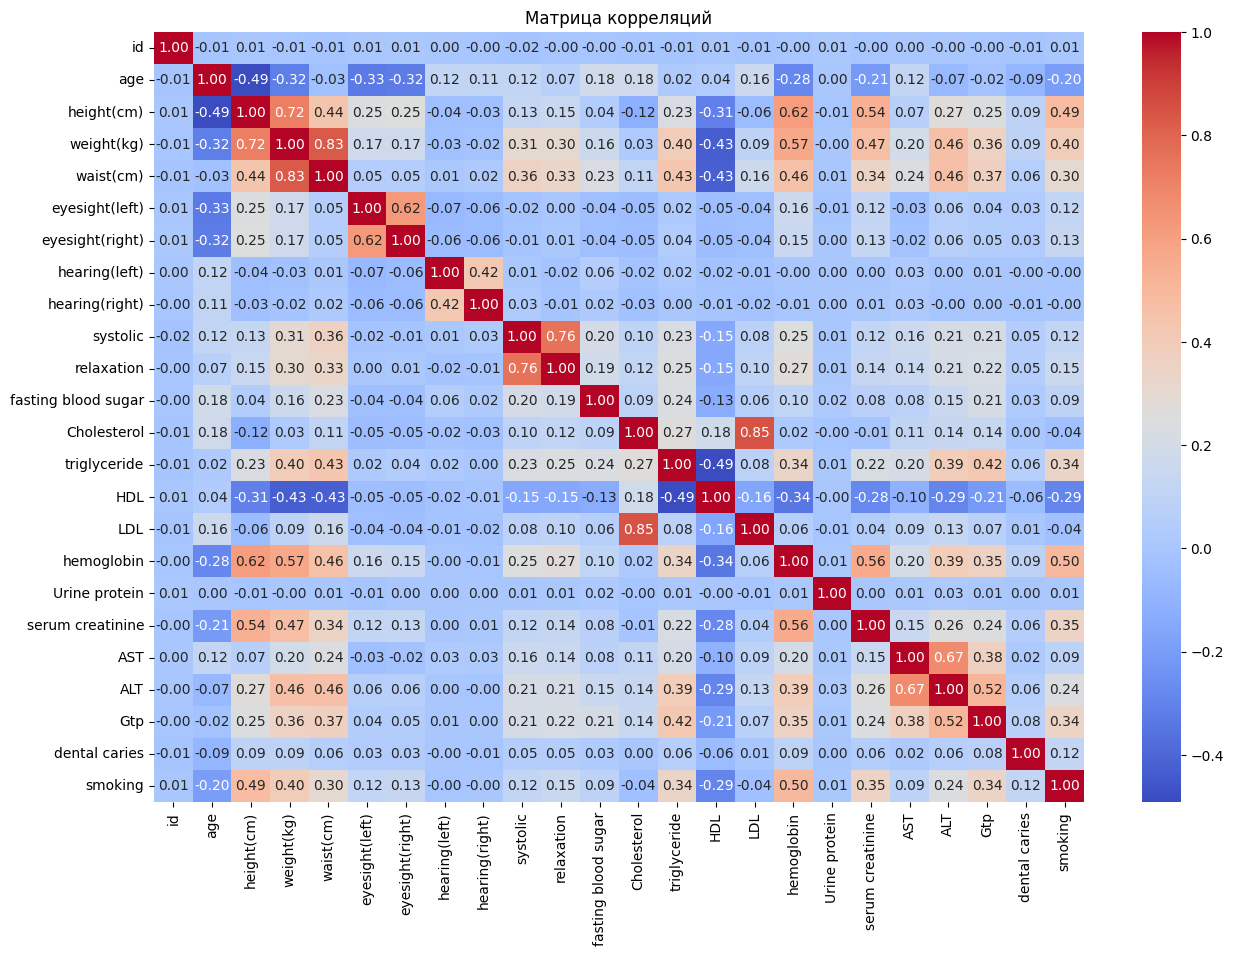

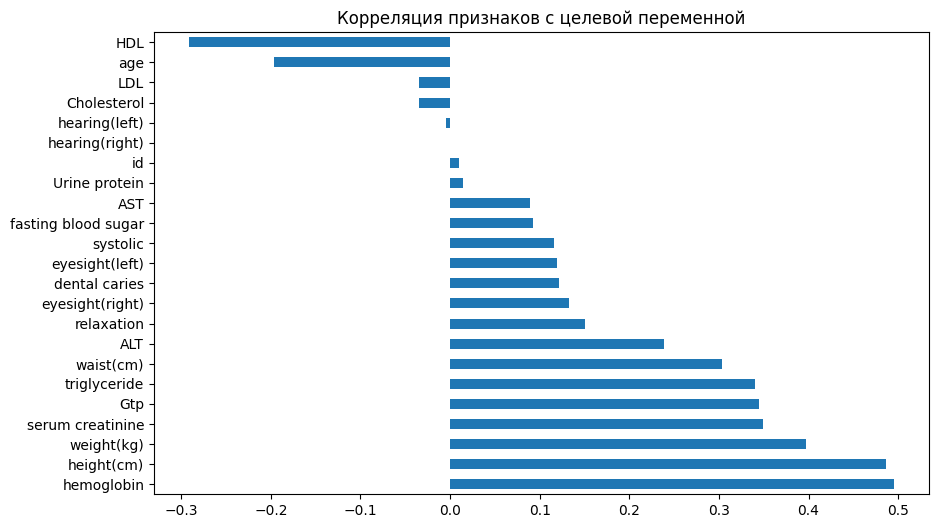

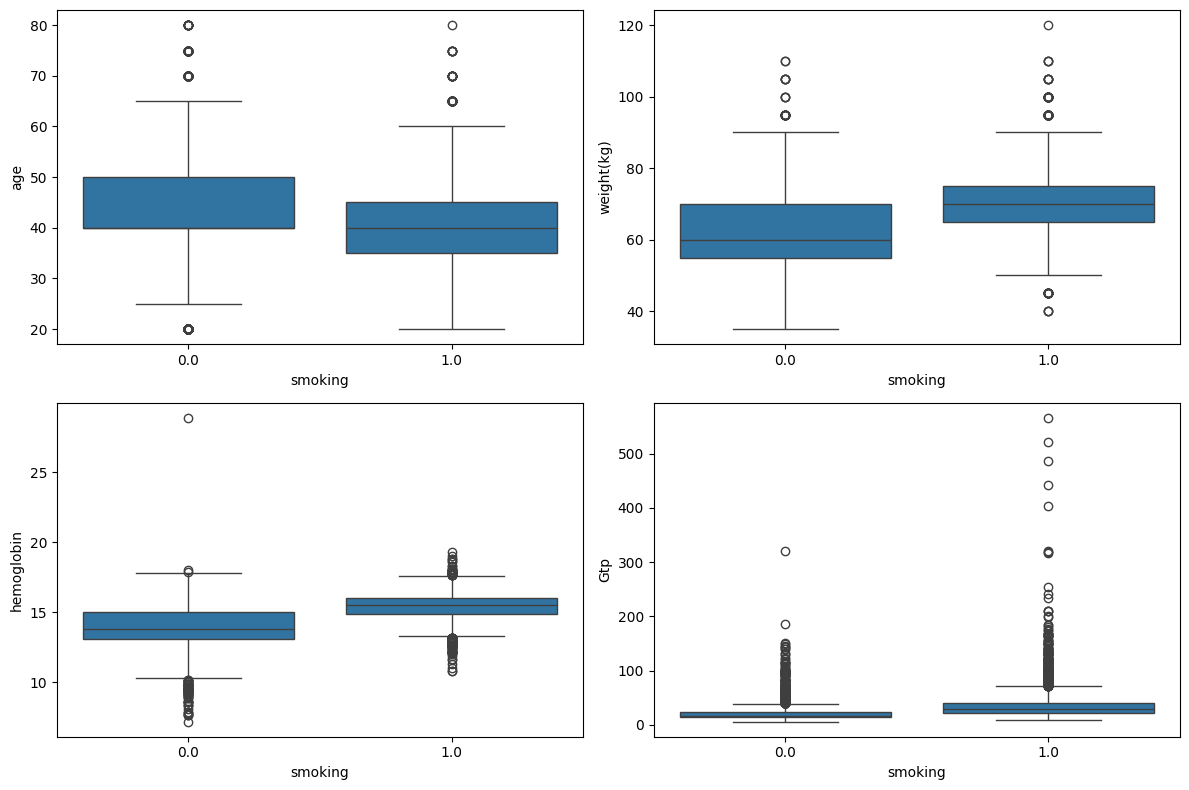

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import cross_val_score

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(train_df.head())
print(train_df.info())
print(train_df.describe())

print(train_df.isnull().sum())

plt.figure(figsize=(6, 4))
sns.countplot(x='smoking', data=train_df)
plt.title('Распределение целевой переменной smoking')
plt.show()

plt.figure(figsize=(15, 10))
corr_matrix = train_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

plt.figure(figsize=(10, 6))
corr_matrix['smoking'].sort_values(ascending=False)[1:].plot(kind='barh')
plt.title('Корреляция признаков с целевой переменной')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.boxplot(x='smoking', y='age', data=train_df, ax=axes[0, 0])
sns.boxplot(x='smoking', y='weight(kg)', data=train_df, ax=axes[0, 1])
sns.boxplot(x='smoking', y='hemoglobin', data=train_df, ax=axes[1, 0])
sns.boxplot(x='smoking', y='Gtp', data=train_df, ax=axes[1, 1])
plt.tight_layout()
plt.show()

X = train_df.drop(['id', 'smoking'], axis=1)
y = train_df['smoking']
X_test = test_df.drop('id', axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

##**Реализация бэггинга**

In [6]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone

class MyBaggingClassifier:
    def __init__(self, base_estimator=None, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator if base_estimator else DecisionTreeClassifier()
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.estimators_ = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        for _ in range(self.n_estimators):
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample = X[indices]
            y_sample = y.iloc[indices] if hasattr(y, 'iloc') else y[indices]

            estimator = clone(self.base_estimator)
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)

    def predict_proba(self, X):
        probas = [estimator.predict_proba(X) for estimator in self.estimators_]
        return np.mean(probas, axis=0)

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score

my_bagging = MyBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                n_estimators=50, random_state=42)
my_bagging.fit(X_train, y_train)
my_bagging_pred = my_bagging.predict_proba(X_valid)[:, 1]
my_bagging_auc = roc_auc_score(y_valid, my_bagging_pred)

sklearn_bagging = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                  n_estimators=50,
                                  random_state=42)
sklearn_bagging.fit(X_train, y_train)
sklearn_bagging_pred = sklearn_bagging.predict_proba(X_valid)[:, 1]
sklearn_bagging_auc = roc_auc_score(y_valid, sklearn_bagging_pred)

print(f'ROC-AUC: {my_bagging_auc:.4f}')
print(f'ROC-AUC sklearn бэггинга: {sklearn_bagging_auc:.4f}')

ROC-AUC: 0.8561
ROC-AUC sklearn бэггинга: 0.8575


##**Реализация градиентного бустинга**

In [7]:
from sklearn.tree import DecisionTreeRegressor

class MyGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators_ = []
        self.initial_prediction = None

    def fit(self, X, y):
        np.random.seed(self.random_state)
        pos_class_prob = np.mean(y)
        self.initial_prediction = np.log(pos_class_prob / (1 - pos_class_prob))

        current_prediction = np.full(len(y), self.initial_prediction, dtype=float)

        for _ in range(self.n_estimators):
            p = self._sigmoid(current_prediction)
            residuals = y - p

            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X, residuals)

            leaf_preds = tree.predict(X)
            current_prediction += self.learning_rate * leaf_preds

            self.estimators_.append(tree)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def predict_proba(self, X):
        pred = np.full(X.shape[0], self.initial_prediction, dtype=float)
        for tree in self.estimators_:
            pred += self.learning_rate * tree.predict(X)
        proba = self._sigmoid(pred)
        return np.vstack([1-proba, proba]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)

my_gb = MyGradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
my_gb.fit(X_train, y_train)
my_gb_pred = my_gb.predict_proba(X_valid)[:, 1]
my_gb_auc = roc_auc_score(y_valid, my_gb_pred)

sklearn_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
sklearn_gb.fit(X_train, y_train)
sklearn_gb_pred = sklearn_gb.predict_proba(X_valid)[:, 1]
sklearn_gb_auc = roc_auc_score(y_valid, sklearn_gb_pred)

print(f'ROC-AUC: {my_gb_auc:.4f}')
print(f'ROC-AUC sklearn GB: {sklearn_gb_auc:.4f}')

ROC-AUC: 0.8700
ROC-AUC sklearn GB: 0.8898


##**Сравнение алгоритмов градиентного бустинга**

In [8]:
from sklearn import set_config
set_config(transform_output="pandas")

lgb_model = lgb.LGBMClassifier(random_state=42, force_row_wise=True)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict_proba(X_valid)[:, 1]
lgb_auc = roc_auc_score(y_valid, lgb_pred)

xgb_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    enable_categorical=False
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict_proba(X_valid)[:, 1]
xgb_auc = roc_auc_score(y_valid, xgb_pred)

cat_model = CatBoostClassifier(random_state=42, verbose=0)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict_proba(X_valid)[:, 1]
cat_auc = roc_auc_score(y_valid, cat_pred)

print(f'LightGBM ROC-AUC: {lgb_auc:.4f}')
print(f'XGBoost ROC-AUC: {xgb_auc:.4f}')
print(f'CatBoost ROC-AUC: {cat_auc:.4f}')
print(f'Sklearn GB ROC-AUC: {sklearn_gb_auc:.4f}')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4359, number of negative: 7641
[LightGBM] [Info] Total Bins 1447
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.363250 -> initscore=-0.561286
[LightGBM] [Info] Start training from score -0.561286


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM ROC-AUC: 0.8901
XGBoost ROC-AUC: 0.8813
CatBoost ROC-AUC: 0.8921
Sklearn GB ROC-AUC: 0.8898


##**Подбор гиперпараметров с Optuna**

In [9]:
import warnings
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
    }

    model = xgb.XGBClassifier(**params, random_state=42, eval_metric='logloss')
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    return score

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

best_params = study.best_params
print('Лучшие параметры:', best_params)

best_xgb = xgb.XGBClassifier(**best_params, random_state=42, eval_metric='logloss')
best_xgb.fit(X_train, y_train)
best_xgb_pred = best_xgb.predict_proba(X_valid)[:, 1]
best_xgb_auc = roc_auc_score(y_valid, best_xgb_pred)
print(f'Лучший XGBoost ROC-AUC: {best_xgb_auc:.4f}')

[I 2025-05-23 18:30:02,479] A new study created in memory with name: no-name-bc1c9980-6a35-46cc-9a25-cd24d086ef20
[I 2025-05-23 18:30:03,065] Trial 0 finished with value: 0.8787077321217726 and parameters: {'n_estimators': 125, 'learning_rate': 0.1807570369698813, 'max_depth': 5, 'subsample': 0.6074865155702727, 'colsample_bytree': 0.8734595240376974, 'min_child_weight': 1, 'reg_alpha': 0.8734456536938556, 'reg_lambda': 0.46110010274339985}. Best is trial 0 with value: 0.8787077321217726.
[I 2025-05-23 18:30:04,799] Trial 1 finished with value: 0.8685644051051069 and parameters: {'n_estimators': 327, 'learning_rate': 0.24644918810535726, 'max_depth': 8, 'subsample': 0.7199730516198924, 'colsample_bytree': 0.8999866737487249, 'min_child_weight': 7, 'reg_alpha': 0.7875285080251849, 'reg_lambda': 0.9501045689513657}. Best is trial 0 with value: 0.8787077321217726.
[I 2025-05-23 18:30:05,043] Trial 2 finished with value: 0.8755750234657041 and parameters: {'n_estimators': 54, 'learning_rat

Лучшие параметры: {'n_estimators': 454, 'learning_rate': 0.04708333887588691, 'max_depth': 4, 'subsample': 0.9387464557380246, 'colsample_bytree': 0.7224131956394036, 'min_child_weight': 9, 'reg_alpha': 0.7307216093445563, 'reg_lambda': 0.914544695584433}
Лучший XGBoost ROC-AUC: 0.8938


##**Реализация метрик**

In [10]:
def my_accuracy_score(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return correct / len(y_true)

def my_precision_score(y_true, y_pred):
    true_pos = np.sum((y_true == 1) & (y_pred == 1))
    false_pos = np.sum((y_true == 0) & (y_pred == 1))
    return true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0

def my_recall_score(y_true, y_pred):
    true_pos = np.sum((y_true == 1) & (y_pred == 1))
    false_neg = np.sum((y_true == 1) & (y_pred == 0))
    return true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0

def my_f1_score(y_true, y_pred):
    precision = my_precision_score(y_true, y_pred)
    recall = my_recall_score(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

y_pred = best_xgb.predict(X_valid)

print('Accuracy:')
print('Моя реализация:', my_accuracy_score(y_valid, y_pred))
print('Sklearn:', accuracy_score(y_valid, y_pred))

print('\nPrecision:')
print('Моя реализация:', my_precision_score(y_valid, y_pred))
print('Sklearn:', precision_score(y_valid, y_pred))

print('\nRecall:')
print('Моя реализация:', my_recall_score(y_valid, y_pred))
print('Sklearn:', recall_score(y_valid, y_pred))

print('\nF1-score:')
print('Моя реализация:', my_f1_score(y_valid, y_pred))
print('Sklearn:', f1_score(y_valid, y_pred))

Accuracy:
Моя реализация: 0.8146666666666667
Sklearn: 0.8146666666666667

Precision:
Моя реализация: 0.7437395659432388
Sklearn: 0.7437395659432388

Recall:
Моя реализация: 0.781578947368421
Sklearn: 0.781578947368421

F1-score:
Моя реализация: 0.7621899059024807
Sklearn: 0.7621899059024807


##**Дополнительные метрики**

In [11]:
def my_roc_auc_score(y_true, y_score):
    sorted_indices = np.argsort(y_score)[::-1]
    y_true_sorted = y_true.iloc[sorted_indices]
    y_score_sorted = y_score[sorted_indices]

    thresholds = np.unique(y_score_sorted)
    tpr = []
    fpr = []

    for threshold in thresholds:
        y_pred = (y_score_sorted >= threshold).astype(int)
        tp = np.sum((y_true_sorted == 1) & (y_pred == 1))
        fp = np.sum((y_true_sorted == 0) & (y_pred == 1))
        fn = np.sum((y_true_sorted == 1) & (y_pred == 0))
        tn = np.sum((y_true_sorted == 0) & (y_pred == 0))

        tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)

    fpr, tpr = zip(*sorted(zip(fpr, tpr)))

    auc = 0
    for i in range(1, len(tpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2

    return auc

def my_pr_auc_score(y_true, y_score):
    sorted_indices = np.argsort(y_score)[::-1]
    y_true_sorted = y_true.iloc[sorted_indices]
    y_score_sorted = y_score[sorted_indices]

    thresholds = np.unique(y_score_sorted)
    precision = []
    recall = []

    for threshold in thresholds:
        y_pred = (y_score_sorted >= threshold).astype(int)
        tp = np.sum((y_true_sorted == 1) & (y_pred == 1))
        fp = np.sum((y_true_sorted == 0) & (y_pred == 1))
        fn = np.sum((y_true_sorted == 1) & (y_pred == 0))

        precision.append(tp / (tp + fp) if (tp + fp) > 0 else 1)
        recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

    recall = [0] + recall
    precision = [1] + precision
    recall, precision = zip(*sorted(zip(recall, precision)))

    auc = 0
    for i in range(1, len(precision)):
        auc += (recall[i] - recall[i-1]) * (precision[i] + precision[i-1]) / 2
    return auc

y_score = best_xgb.predict_proba(X_valid)[:, 1]
print('ROC-AUC:')
print('Моя реализация:', my_roc_auc_score(y_valid, y_score))
print('Sklearn:', roc_auc_score(y_valid, y_score))

print('\nPR-AUC:')
print('Моя реализация:', my_pr_auc_score(y_valid, y_score))
print('Sklearn:', average_precision_score(y_valid, y_score))


ROC-AUC:
Моя реализация: 0.8938436144123864
Sklearn: 0.8938436144123749

PR-AUC:
Моя реализация: 0.8012418458518284
Sklearn: 0.8015024408572222


##**Финализация модели и создание submission файла**

In [12]:
final_model = xgb.XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
final_model.fit(X_scaled, y)

test_pred = final_model.predict_proba(X_test_scaled)[:, 1]

submission = pd.DataFrame({
    'id': test_df['id'],
    'smoking': test_pred
})
submission.to_csv('submission.csv', index=False)

print('Submission файл создан!')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:34:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Submission файл создан!
